In [0]:
# Update with your NetID
netid = "aiyer01"

In [0]:
# Loads the data and splits the labels (target output) from the input
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/garrettkatz/computer-conscience/master/modules/ml/training/data/fake.csv", index_col=0)
labels = data.pop("recidivist")

# Extracts features from raw data
# replaces non-numeric categories with one-hot encodings
features = data.copy()
features["male"] = (features["gender"] == "Male").astype(int)
features["female"] = (features["gender"] == "Female").astype(int)
features = features.drop(columns="gender")
features["african-american"] = (features["race"] == "African-American").astype(int)
features["caucasian"] = (features["race"] == "Caucasian").astype(int)
features["hispanic"] = (features["race"] == "Hispanic").astype(int)
features["asian"] = (features["race"] == "Asian").astype(int)
features["native american"] = (features["race"] == "Native American").astype(int)
features["other"] = (features["race"] == "Other").astype(int)
features = features.drop(columns="race")
features = features.drop(columns=["recidivism risk score", "first name", "last name", "full name", "risk assessment date", "date of birth"])

In [25]:
# Display the data
data

,gender,race,age,number of prior convictions,recidivism risk score,first name,last name,full name,risk assessment date,date of birth
0,Male,African-American,48,12,6,John,Doe,John Doe,2018-05-24,1970-05-24
1,Male,Caucasian,28,2,2,John,Doe,John Doe,2018-03-18,1990-03-18
2,Male,Other,35,0,1,John,Doe,John Doe,2018-02-02,1983-02-02
3,Female,Other,33,0,2,Jane,Doe,Jane Doe,2018-03-19,1985-03-18
4,Female,Hispanic,25,0,3,Jane,Doe,Jane Doe,2018-06-22,1993-06-21
...,...,...,...,...,...,...,...,...,...,...
4015,Female,Other,33,0,2,Jane,Doe,Jane Doe,2019-08-13,1986-08-12
4016,Male,African-American,35,6,8,John,Doe,John Doe,2018-09-19,1983-09-19
4017,Male,Caucasian,24,3,5,John,Doe,John Doe,2019-04-10,1995-04-10
4018,Female,Caucasian,46,0,1,Jane,Doe,Jane Doe,2018-04-08,1972-04-07


In [26]:
# Display the features
features

,age,number of prior convictions,male,female,african-american,caucasian,hispanic,asian,native american,other
0,48,12,1,0,1,0,0,0,0,0
1,28,2,1,0,0,1,0,0,0,0
2,35,0,1,0,0,0,0,0,0,1
3,33,0,0,1,0,0,0,0,0,1
4,25,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4015,33,0,0,1,0,0,0,0,0,1
4016,35,6,1,0,1,0,0,0,0,0
4017,24,3,1,0,0,1,0,0,0,0
4018,46,0,0,1,0,1,0,0,0,0


(0, 3121, 0, 3121.0)
(1, 2179, 93, 2272.0)
(2, 1703, 165, 1868.0)
(3, 1326, 245, 1571.0)
(4, 972, 328, 1300.0)
(5, 693, 417, 1110.0)
(6, 481, 491, 972.0)
(7, 298, 594, 892.0)
(8, 181, 704, 885.0)
(9, 67, 816, 883.0)
(10, 0, 898, 898.0)


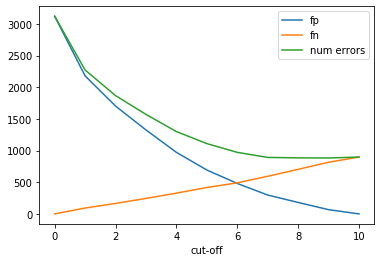

In [27]:
# False positives and negatives based on recidivism risk score
def assess_risk_score(data, labels, cutoff):
  """
  Assesses the following rule based on COMPAS risk score to predict recidivism:
    If the risk score is greater than the cut-off,
    then predict that the individual is a recidivist.
  A prediction of 1 means the criminal will be a recidivist
  A prediction of 0 means the criminal will not be a recidivist
  Measures prediction performance using the true labels from the data.
  Returns a tuple (fp, fn, er):
    fp: the number of false positives (wrongly predicted recidivism = 1)
    fn: the number of false negatives (wrongly predicted recidivism = 0)
    er: the error rate (number of false predictions divided by size of dataset)
  """
  false_positives = 0
  false_negatives = 0
  error = 0

  for i in range(len(data)):
    score = data.iloc[i]['recidivism risk score']
    lab = labels[i]
    predict = 0
    if score > cutoff:
      predict = 1
    else:
      predict = 0
    if predict == 1 and lab == 0:
      false_positives = false_positives+1
      error = error+1
    elif predict == 0 and lab == 1:
      false_negatives = false_negatives+1
      error = error+1
  error_rate = error/(len(data))
  return false_positives, false_negatives, error_rate

# Prints and plots the results
x, y = [], []
for cutoff in range(11):
  fp, fn, er = assess_risk_score(data, labels, cutoff)
  print((cutoff, fp, fn, er * data.shape[0]))
  x.append(cutoff)
  y.append((fp, fn, er * data.shape[0]))

import matplotlib.pyplot as pt
pt.plot(x, y)
pt.xlabel("cut-off")
pt.legend(["fp","fn","num errors"])

In [28]:
# Training a neural network to predict recidivism
import numpy as np
import torch as tr

# Helper function converts pandas dataframe to pytorch tensor:
def to_tensor(df): return tr.tensor(df.values.astype(np.float32))

inputs, targets = to_tensor(features), to_tensor(labels)

# Neural network class definition
class Net(tr.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # The number of neurons in the hidden layer should be twice the length of your NetID
    # l1 is the layer from input to hidden
    # l2 is the layer from hidden to output
    # Both should use the Linear module in torch.nn
    neurons = 2*len(netid)
    self.l1 = tr.nn.Linear(features.shape[1],neurons)
    self.l2 = tr.nn.Linear(neurons,1)
  def forward(self, x):
    # Define the network's forward pass
    # For an input feature vector x, should return a scalar output y
    # y should be between 0 and 1, indicating the recidivism prediction
    # Use tanh for the hidden layer activation
    # Use sigmoid for the output node activation
    x0 = self.l1(x)
    a1 = tr.nn.functional.tanh(x0)
    x2 = self.l2(a1)
    y = tr.nn.functional.sigmoid(x2)
    print(y)
    return y


# The following runs gradient descent on the data
net = Net()
optimizer = tr.optim.SGD(net.parameters(), lr=0.01/inputs.shape[0])
num_epochs = 10000
for epoch in range(num_epochs):
  # Start with zero gradient
  optimizer.zero_grad()

  # Calculate network output and sum of squared loss for each datapoint
  y = net(inputs)
  
  loss = ((y.squeeze() - targets.squeeze())**2).sum()

  # Calculate gradients and take a descent step
  loss.backward()
  optimizer.step()

  # Monitor optimization progress
  num_errors = (y.squeeze().round().detach().numpy() != targets.numpy()).sum()
  if epoch % (num_epochs/10) == 0: print(loss, num_errors)

# Print predicted and target outputs for the first 10 datapoints 
print(y.squeeze()[:10])
print(y.squeeze()[:10].round())
print(targets[:10].squeeze())
print((y.squeeze().detach().numpy() > .5).any())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.5348],
        [0.5231],
        [0.5215],
        ...,
        [0.5240],
        [0.5212],
        [0.5260]], grad_fn=<SigmoidBackward>)
tensor(1056.5404, grad_fn=<SumBackward0>) 3122
tensor([[0.5281],
        [0.5172],
        [0.5156],
        ...,
        [0.5182],
        [0.5152],
        [0.5197]], grad_fn=<SigmoidBackward>)
tensor([[0.5215],
        [0.5114],
        [0.5099],
        ...,
        [0.5124],
        [0.5095],
        [0.5136]], grad_fn=<SigmoidBackward>)
tensor([[0.5151],
        [0.5058],
        [0.5043],
        ...,
        [0.5068],
        [0.5039],
        [0.5077]], grad_fn=<SigmoidBackward>)
tensor([[0.5090],
        [0.5003],
        [0.4988],
        ...,
        [0.5014],
        [0.4984],
        [0.5019]], grad_fn=<SigmoidBackward>)
tensor([[0.5030],
        [0.4950],
        [0.4935],
        ...,
        [0.4960],
        [0.4930],
        [0.4964]], grad_fn=<SigmoidBackward>)
tensor([[0.4972],
        [0.4897],
        [0.4883],
     

In [0]:
# runs tests
fp, fn, er = assess_risk_score(data, labels, 2)
assert(fp == 1703 and fn == 165 and er*data.shape[0] == 1868.0)
fp, fn, er = assess_risk_score(data, labels, 6)
assert(fp == 481 and fn == 491 and er*data.shape[0] == 972.0)

n = Net()
assert(n.l1.weight.shape == (2*len(netid), features.shape[1]))
assert(n.l2.weight.shape == (1, 2*len(netid)))